In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pickle
sns.set_theme()

# jupyter notebook full-width display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# no text wrapping
display(HTML("<style>.dataframe td { white-space: nowrap; }</style>"))

# pandas formatting
pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_colwidth', 200)

# Import Data From Preliminary Analysis
df_hist = pd.read_pickle('calculations\df_hist.pickle')
df_spec = pd.read_pickle('calculations\df_spec.pickle')
df_summary = pd.read_pickle('calculations\df_summary.pickle')

In [2]:
# plotting function

def plot_fork_length_by_sample(df_specimen, df_historical, sample_id, feature='fork_length', bin_width=5, density=False, subtitle='', duplicate='unknown', right=False):
    """ duplicate can be True, False, or 'unknown' """
    
    figsize=(16,4)
    offset = 0.1 if right else 0  # this is a hack - plt.hist() doesn't seem to have a right inclusive option for bins...
    bins_plot = [x*5+offset + 20 for x in range(30)]  # centered on n%5==3 like df_spec, rounded to int%5 (could use +20.5 also to center perfectly on n%5==3)
    
    if duplicate == 'unknown':
        colours = sns.color_palette()[0], sns.color_palette('pastel')[1]
    elif duplicate: # duplicated
        colours = sns.color_palette()[0], sns.color_palette('pastel')[2]
    else: # not duplicated
        colours = sns.color_palette()[0], sns.color_palette('deep')[6]
        
    plt.figure(figsize=figsize)
    plt.xlim(20, 170)  # use same scale for all histograms for easy comparison
    df_specimen.loc[df_specimen.sample_id==sample_id, feature].dropna().hist(alpha=0.6, color=colours[0], density=density, label=f'Specimen {feature}', bins=bins_plot)
    df_historical.loc[df_historical.sample_id==sample_id, feature].dropna().hist(alpha=0.8, color=colours[1], density=density, label=f'Bioligical {feature}', bins=bins_plot, rwidth=0.7)
    
    feature_title = feature.title().replace("_"," ")
    plt.legend(loc='upper right')
    subtitle = ' - ' + subtitle if subtitle else ''
    plt.title(f'Sample {sample_id}: {feature_title} Comparison - Specimen vs Biological Data{subtitle}')
    plt.ylabel('Counts')
    plt.xlabel(f'{feature_title}')
    plt.show()


In [3]:
# improved matching function

def match_spec_and_bio(df_specimen, df_bio, n_sample, debug=False, right=False):

    # create bins for fork lengths, create lists representing counts per bin
    bins = [x for x in range(20, 170, 5)]
    bin_s = df_specimen[df_specimen.sample_id==n_sample].groupby(['sample_id', pd.cut(df_specimen.fork_length, bins, right=right)]).fork_length.count().to_list()
    bin_b = df_bio[df_bio.sample_id==n_sample].groupby(['sample_id', pd.cut(df_bio.fork_length, bins, right=right)]).fork_length.count().to_list()
    
    if debug:
        print('bins')
        print(bin_s)
        print(bin_b)
        print()
    
    # difference between two lists of fish counts
    list_diff = []
    for i, bin in enumerate(bin_b):
        bin_s[i] = bin_s[i] - bin
        list_diff += [bin_s[i]]
        
    # evaluate how far negative counts (unmatched fish) are from matchable entries
    n = 0
    i_max = len(list_diff)
    for i, bin in enumerate(list_diff):
        if debug:
            print(i, 'list_diff')
            print(list_diff)
        if bin < 0:
            for j in range(1, i_max):  
                if i-j >= 0:
                    if (subtract := list_diff[i-j]) > 0:
                        subtract = subtract if subtract <= -bin else -bin
                        list_diff[i-j] -= subtract
                        bin += subtract
                        n += j * subtract
                        if bin == 0:
                            break  # break the j loop   
                if i+j < i_max:
                    if (subtract := list_diff[i+j]) > 0:
                        subtract = subtract if subtract <= -bin else -bin
                        list_diff[i+j] -= subtract
                        bin += subtract
                        n += j * subtract
                        if bin == 0:
                            break
            list_diff[i] = bin

            if bin < 0:  # unmatchable penalty
                return 9999

    if debug:
        print()
        print(n)
        print(list_diff)

    return n * 5  # 5 is the bin width, ie, the error per fish per bin distance


# testing

right==True ERROR: 0


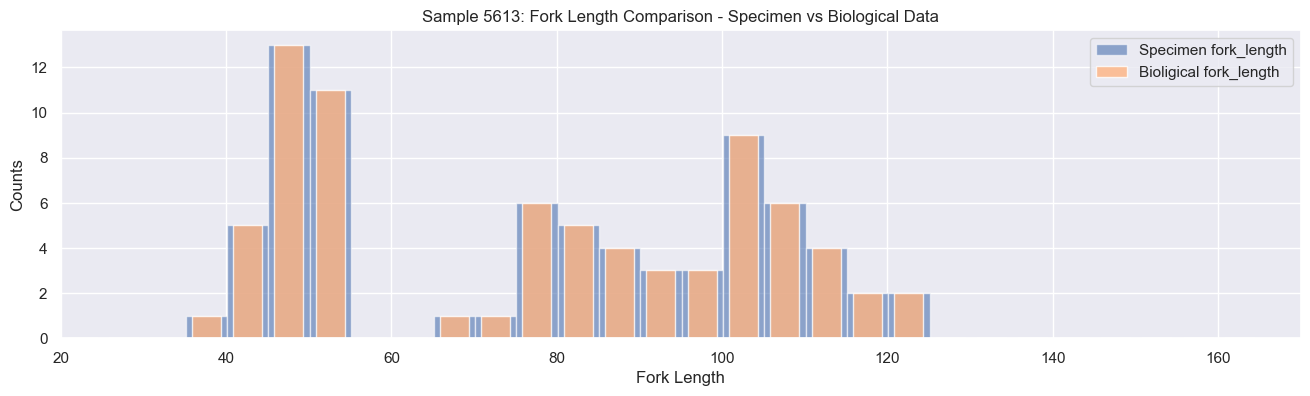

right==False ERROR: 115


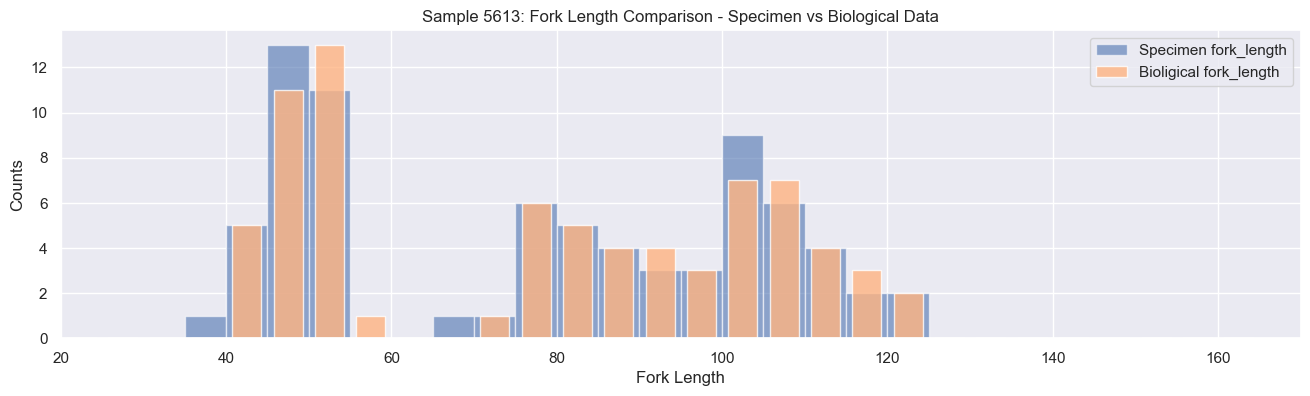

In [4]:
# this is surprising - it is right inclusive, plt is left inclusive, so the bins don't match
# pd.cut defaults to right inclusive, but plt.hist only has left inclusive bins

n_sample = 5613
print('right==True ERROR:', match_spec_and_bio(df_spec, df_hist, n_sample, right=True))
plot_fork_length_by_sample(df_spec, df_hist, n_sample, right=True)
print('right==False ERROR:', match_spec_and_bio(df_spec, df_hist, n_sample, right=False))
plot_fork_length_by_sample(df_spec, df_hist, n_sample, right=False)

# check whether right or left inclusive is better

In [5]:
sample_ids = [x for x in df_hist.sample_id.unique() if x in df_spec.sample_id.unique()]

In [6]:
%%time
left_vs_right = []
for i in sample_ids:
    left_vs_right += [[i, match_spec_and_bio(df_spec, df_hist, i, right=False), match_spec_and_bio(df_spec, df_hist, i, right=True)]]

Wall time: 21.7 s


In [7]:
df_left_vs_right = pd.DataFrame(left_vs_right, columns=['sample_id', 'left_error', 'right_error'])

In [8]:
df_left_vs_right.describe(percentiles=[.01, .1, .9, .99])

,sample_id,left_error,right_error
count,775.000,775.000,775.000
mean,6398.706,191.289,159.470
std,1346.040,1182.737,1184.284
min,4404.000,0.000,0.000
1%,4433.480,0.000,0.000
10%,4548.400,0.000,0.000
50%,7168.000,10.000,0.000
90%,7811.600,150.000,35.000
99%,7981.260,9999.000,9999.000
max,8001.000,9999.000,9999.000


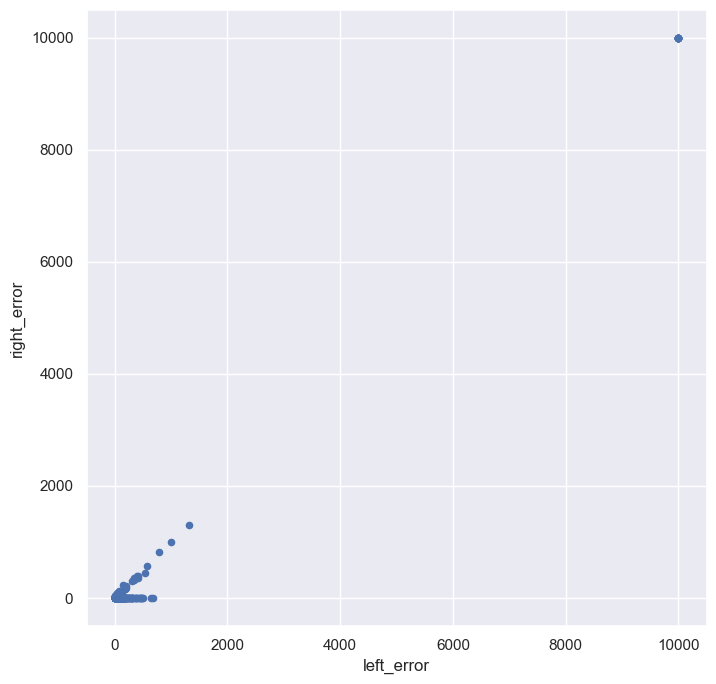

In [9]:
# Wow, right is WAAAAAYYY better!
df_left_vs_right.plot(kind='scatter', x='left_error', y='right_error', figsize=(8,8));

# Rough Work

In [10]:
# how much error is in this set of bins?

bin_s = [0,0,0,0,2,3,6,5,4,3,6,1,0,0,0]
bin_b = [0,0,0,1,0,0,1,2,1,1,2,2,0,0,0]
list_out = []

for i, bin in enumerate(bin_b):
    bin_out = bin - bin_s[i]
    bin_out = bin_out if bin_out >= 0 else 0
    list_out += [bin_out]
    
list_out

[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]

In [11]:
bin_s = [0,0,1,0,2,3,6,5,4,3,6,0,0,0,0]
bin_b = [0,0,0,4,0,0,1,2,1,1,2,0,1,0,0]
list_diff = []

for i, bin in enumerate(bin_b):
    bin_s[i] = bin_s[i] - bin
    list_diff += [bin_s[i]]
    
list_diff

[0, 0, 1, -4, 2, 3, 5, 3, 3, 2, 4, 0, -1, 0, 0]

In [12]:
list_diff = [0, 0, 1, -4, 2, 3, 5, 3, 3, 2, 4, 0, -1, 0, 0]
n = 0
i_max = len(list_diff)

print(list_diff)


for i, bin in enumerate(list_diff):
    print(list_diff)
    if bin < 0:
        for j in range(1, i_max):  
            if i-j >= 0:
                if (subtract := list_diff[i-j]) > 0:
                    subtract = subtract if subtract <= -bin else -bin
                    list_diff[i-j] -= subtract
                    bin += subtract
                    n += j * subtract
                    if bin == 0:
                        break  # break the j loop   
            if i+j < i_max:
                if (subtract := list_diff[i+j]) > 0:
                    subtract = subtract if subtract <= -bin else -bin
                    list_diff[i+j] -= subtract
                    bin += subtract
                    n += j * subtract
                    if bin == 0:
                        break
        list_diff[i] = bin
            
        if bin < 0:  # unmatchable penalty
            n = 999
            break  # break the i loop
        
print()
print(n)
print(list_diff)

[0, 0, 1, -4, 2, 3, 5, 3, 3, 2, 4, 0, -1, 0, 0]
[0, 0, 1, -4, 2, 3, 5, 3, 3, 2, 4, 0, -1, 0, 0]
[0, 0, 1, -4, 2, 3, 5, 3, 3, 2, 4, 0, -1, 0, 0]
[0, 0, 1, -4, 2, 3, 5, 3, 3, 2, 4, 0, -1, 0, 0]
[0, 0, 1, -4, 2, 3, 5, 3, 3, 2, 4, 0, -1, 0, 0]
[0, 0, 0, 0, 0, 2, 5, 3, 3, 2, 4, 0, -1, 0, 0]
[0, 0, 0, 0, 0, 2, 5, 3, 3, 2, 4, 0, -1, 0, 0]
[0, 0, 0, 0, 0, 2, 5, 3, 3, 2, 4, 0, -1, 0, 0]
[0, 0, 0, 0, 0, 2, 5, 3, 3, 2, 4, 0, -1, 0, 0]
[0, 0, 0, 0, 0, 2, 5, 3, 3, 2, 4, 0, -1, 0, 0]
[0, 0, 0, 0, 0, 2, 5, 3, 3, 2, 4, 0, -1, 0, 0]
[0, 0, 0, 0, 0, 2, 5, 3, 3, 2, 4, 0, -1, 0, 0]
[0, 0, 0, 0, 0, 2, 5, 3, 3, 2, 4, 0, -1, 0, 0]
[0, 0, 0, 0, 0, 2, 5, 3, 3, 2, 4, 0, -1, 0, 0]
[0, 0, 0, 0, 0, 2, 5, 3, 3, 2, 3, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 2, 5, 3, 3, 2, 3, 0, 0, 0, 0]

7
[0, 0, 0, 0, 0, 2, 5, 3, 3, 2, 3, 0, 0, 0, 0]


In [13]:
list_diff = [0, -100, 1, -4, 2, 3, 5, 3, 3, 2, 4, 0, -1, 0, 0]
n = 0
i_max = len(list_diff)

print(list_diff)


for i, bin in enumerate(list_diff):
    print(list_diff)
    if bin < 0:
        for j in range(1, i_max):  
            if i-j >= 0:
                if (subtract := list_diff[i-j]) > 0:
                    subtract = subtract if subtract <= -bin else -bin
                    list_diff[i-j] -= subtract
                    bin += subtract
                    n += j * subtract
                    if bin == 0:
                        break  # break the j loop   
            if i+j < i_max:
                if (subtract := list_diff[i+j]) > 0:
                    subtract = subtract if subtract <= -bin else -bin
                    list_diff[i+j] -= subtract
                    bin += subtract
                    n += j * subtract
                    if bin == 0:
                        break
        list_diff[i] = bin
            
        if bin < 0:  # unmatchable penalty
            n = 9999
            break  # break the i loop
        
print()
print(n)
print(list_diff)

[0, -100, 1, -4, 2, 3, 5, 3, 3, 2, 4, 0, -1, 0, 0]
[0, -100, 1, -4, 2, 3, 5, 3, 3, 2, 4, 0, -1, 0, 0]
[0, -100, 1, -4, 2, 3, 5, 3, 3, 2, 4, 0, -1, 0, 0]

9999
[0, -77, 0, -4, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0]
